# 树回归与标准回归的比较

**说明:**

将 `bikeSpeedVsIq_train.txt` 和 `bikeSpeedVsIq_test.txt` 放在当前目录下。

In [1]:
from numpy import *
import matplotlib.pyplot as plt

## 回归树的叶节点生成函数

In [2]:
def regLeaf(dataSet):#returns the value used for each leaf
    return mean(dataSet[:,-1])

def regErr(dataSet):
    return var(dataSet[:,-1]) * shape(dataSet)[0]

## 模型树的叶节点生成函数

In [3]:
def linearSolve(dataSet):   #helper function used in two places
    m,n = shape(dataSet)
    X = mat(ones((m,n))); Y = mat(ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1]; Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

def modelLeaf(dataSet):#create linear model and return coeficients
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(power(Y - yHat,2))

## 树的生成函数

In [4]:
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    tolS = ops[0]; tolN = ops[1]
    #if all the target variables are the same value: quit and return value
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1: #exit cond 1
        return None, leafType(dataSet)
    m,n = shape(dataSet)
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = inf; bestIndex = 0; bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS: 
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    #if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS: 
        return None, leafType(dataSet) #exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):  #exit cond 3
        return None, leafType(dataSet)
    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split

def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):#assume dataSet is NumPy Mat so we can array filtering
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    if feat == None: return val #if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree  

## 用树回归进行预测的代码

In [5]:
def isTree(obj):
    return (type(obj).__name__=='dict')

def regTreeEval(model, inDat):
    return float(model)

def modelTreeEval(model, inDat):
    n = shape(inDat)[1]
    X = mat(ones((1,n+1)))
    X[:,1:n+1]=inDat
    return float(X*model)

def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree): return modelEval(tree, inData)
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']): return treeForeCast(tree['left'], inData, modelEval)
        else: return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']): return treeForeCast(tree['right'], inData, modelEval)
        else: return modelEval(tree['right'], inData)
        
def createForeCast(tree, testData, modelEval=regTreeEval):
    m=len(testData)
    yHat = mat(zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, mat(testData[i]), modelEval)
    return yHat

## 导入数据

In [6]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

In [7]:
trainMat = mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = mat(loadDataSet('bikeSpeedVsIq_test.txt'))

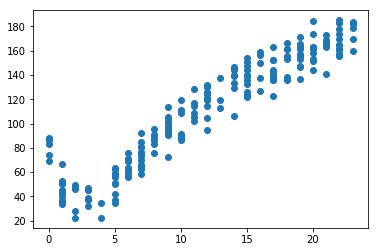

In [8]:
plt.scatter(array(trainMat[:,0]), array(trainMat[:,1]))
plt.show()

## 回归树预测

In [9]:
myTree = createTree(trainMat, ops=(1,20))
yHat = createForeCast(myTree, testMat[:, 0])
corrcoef(yHat, testMat[:, 1], rowvar=0)[0,1]

0.96408523182221406

## 模型树预测

In [10]:
myTree = createTree(trainMat, modelLeaf, modelErr, ops=(1,20))
yHat = createForeCast(myTree, testMat[:,0],modelTreeEval)
corrcoef(yHat, testMat[:, 1], rowvar=0)[0,1]

0.9760412191380593